# Preparation

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

%run functions.py

In [2]:
# Path to initial data tables
genpath = 'init_data/'
organisms = ['arabidopsis', 'pisum', 'oryza', 'cicer']
table = 'feature_table.csv'

path = [genpath + org + '_' + table for org in organisms]

In [3]:
# Make directories for saving classifiers
cdir, sdir, ldir = 'classifiers', 'all', 'best'

cdir = make_dir_if_not_exists('./', cdir)
sdir = make_dir_if_not_exists(cdir, sdir)
ldir = make_dir_if_not_exists(cdir, ldir)

# Import Datasets

In [4]:
# Import A. thaliana data
subs_a, Xa, ya, pph2_prob_a, pph2_pred_a = get_data(path[0])

# Import P. sativum data
subs_p, Xp, yp, pph2_prob_p, pph2_pred_p = get_data(path[1])

# Import O. sativa data
subs_o, Xo, yo, pph2_prob_o, pph2_pred_o = get_data(path[2])

# Import C. arietinum data
subs_c, Xc, _,  pph2_prob_c, pph2_pred_c = get_data(path[3], labels=False)

In [5]:
# Function that scales data relative to A. thaliana
std_data = lambda x: (x - Xa.min()) / (Xa.max() - Xa.min())

stdXa, stdXp, stdXo, stdXc = std_data(Xa), std_data(Xp), std_data(Xo), std_data(Xc)

In [6]:
# Obtain train and test data
# Fix random state in order to get the same separation after running the line below
Xa_train, Xa_test, ya_train, ya_test = train_test_split(stdXa, ya, test_size=1000, random_state=0)

# Computation of Weghts

In [7]:
mean_p, mean_o = stdXp.mean(axis=0), stdXo.mean(axis=0)

# Weights calculations for P. sativum
Wp = [np.exp(-(np.linalg.norm(row - mean_p)) ** 2) for _, row in Xa_train.iterrows()]
Wp = np.array(Wp)

# Weights calculations for O. sativa
Wo = [np.exp(-(np.linalg.norm(row - mean_o)) ** 2) for _, row in Xa_train.iterrows()]
Wo = np.array(Wo)

# Grid Search for Hyperparameters

In [ ]:
# Preparation for grid search
descriptions = ['Linear SVM', 'Gaussian SVM', 'Random Forest']
classifiers = [LinearSVC(), SVC(), RandomForestClassifier()]

# Make the grid; each dict with hyperparameters corresponds to its classifier
parameters = [{'C': [1e+0, 1e+1, 1e+2, 1e+3, 1e+4]},
              {'kernel': ['rbf'],
               'gamma': [2 ** i for i in range(-3, 4)],
               'C': [1e+0, 1e+1, 1e+2, 1e+3, 1e+4]},
              {'n_estimators': list(range(100, 501, 50))}]

In [ ]:
# Search hyperparameters for all classifiers
best_params = []
for desc, ml, pars in zip(descriptions, classifiers, parameters):
    
    clf = GridSearchCV(ml, pars, cv=5, scoring='accuracy')
    clf.fit(Xa_train, ya_train)
    
    best_params.append(clf.best_params_)
    print("Best parameters for {}: {}".format(desc, best_params[-1]))

# Classifiers' Training

In [8]:
n_repeats = 300
accs_wo, accs_wi = [[], [], []], [[], [], []]

In [ ]:
for i in range(n_repeats):
    
    print('{:03} / {:03}'.format(i + 1, n_repeats))
    
    # Fit classifers with the best hyperparameters and without weights
    fitted_wo = [LinearSVC(**best_params[0]).fit(Xa_train, ya_train),
                 SVC(**best_params[1]).fit(Xa_train, ya_train),
                 RandomForestClassifier(**best_params[2]).fit(Xa_train, ya_train)]

    # Fit classifers with both the best hyperparameters and weights obtained for P. sativum data
    fitted_wi_Wp = [LinearSVC(**best_params[0]).fit(Xa_train, ya_train, sample_weight=Wp),
                    SVC(**best_params[1]).fit(Xa_train, ya_train, sample_weight=Wp),
                    RandomForestClassifier(**best_params[2]).fit(Xa_train, ya_train, sample_weight=Wp)]
    
    # Fit classifers with both the best hyperparameters and weights obtained for O. sativa data
    fitted_wi_Wo = [LinearSVC(**best_params[0]).fit(Xa_train, ya_train, sample_weight=Wo),
                    SVC(**best_params[1]).fit(Xa_train, ya_train, sample_weight=Wo),
                    RandomForestClassifier(**best_params[2]).fit(Xa_train, ya_train, sample_weight=Wo)]
    
    rname = '{:03}'.format(i)
    rdir = make_dir_if_not_exists(sdir, rname)
    
    for di, d in enumerate(descriptions):
        d = d.replace(' ', '_')
        
        # Export classifers into files
        c_wo, c_p, c_o = fitted_wo[di], fitted_wi_Wp[di], fitted_wi_Wp[di]
        joblib.dump(c_wo, rdir + d + '_wout_weights.pkl') 
        joblib.dump(c_p, rdir + d + '_with_weights_for_pisum.pkl')
        joblib.dump(c_o, rdir + d + '_with_weights_for_oryza.pkl')
        
        # Accuracy calculation for classifiers fitted without weights 
        accs_wo[di].append([accuracy_score(ya_test, c_wo.predict(Xa_test)),
                                accuracy_score(yp, c_wo.predict(stdXp)),
                                accuracy_score(yo, c_wo.predict(stdXo))])
        
        # Accuracy calculation for classifiers fitted with weights 
        accs_wi[di].append([accuracy_score(yp, c_p.predict(stdXp)),
                            accuracy_score(yo, c_o.predict(stdXo))])


np.save(sdir + 'accuracies_for_all_repeats_and_clfs_wout_weights.npy', np.array(accs_wo))
np.save(sdir + 'accuracies_for_all_repeats_and_clfs_with_weights.npy', np.array(accs_wi))

In [10]:
# Save the tables with RF accuracies for further analysis 
tmp = pd.DataFrame(np.hstack((np.arange(n_repeats).reshape((n_repeats, 1)).astype(np.int), accs_wo[2])),
                   columns=['Clf_Number', 'Acc_Arab', 'Acc_Pisum', 'Acc_Oryza'])
tmp.to_csv(sdir + 'Random_Forest_wout_weights_accuracies.tsv', sep='\t', index=False)

tmp = pd.DataFrame(np.hstack((np.arange(n_repeats).reshape((n_repeats, 1)).astype(np.int), accs_wi[2])),
                   columns=['Clf_Number', 'Acc_Pisum', 'Acc_Oryza'])
tmp.to_csv(sdir + 'Random_Forest_with_weights_accuracies.tsv', sep='\t', index=False)

# Search of the Best Classifiers

In [9]:
# Import tables with accuracies
accs_wo = np.load(sdir + 'accuracies_for_all_repeats_and_clfs_wout_weights.npy')
accs_wi = np.load(sdir + 'accuracies_for_all_repeats_and_clfs_with_weights.npy')

In [ ]:
# Find the repeat which gives minimum Euclidean distance between (1, 1, 1) and
# all accuracy vectors from table related with the absence of weights
dist_wo = ((np.array([1, 1, 1]) - accs_wo) * (np.array([1, 1, 1]) - accs_wo)).sum(axis=2)
min_wo = dist_wo.min(axis=1)
min_ind_wo = np.where(dist_wo[2] == min_wo[2])[0][0]

print('The best classifers fitted without weights are in dir {:03}'.format(min_ind_wo))

# Copy classifers in dir 'best'
copy_clfs(sdir, min_ind_wo, ldir, is_wo_w=True)

In [ ]:
# Find the repeat which gives minimum Euclidean distance between mean accuracy vector and
# all accuracy vectors from table related with the applying of weights
accs_wi_mean = accs_wi.mean(axis=1)
dist_wi = ((accs_wi_mean[2] - accs_wi) * (accs_wi_mean[2] - accs_wi)).sum(axis=2)
min_wi = dist_wi.min(axis=1)
min_ind_wi = np.where(dist_wi[2] == min_wi[2])[0][0]

print('The best classifers fitted with weights are in dir {:03}'.format(min_ind_wi))

# Copy classifers in dir 'best'
copy_clfs(sdir, min_ind_wi, ldir, is_wo_w=False)

# Import of the Best Classifiers

In [11]:
# Import the best classifers fitted without weights 
lsvm_wo = joblib.load(ldir + 'Linear_SVM_wout_weights.pkl')
gsvm_wo = joblib.load(ldir + 'Gaussian_SVM_wout_weights.pkl')
rf_wo   = joblib.load(ldir + 'Random_Forest_wout_weights.pkl')

# Import the best classifers fitted with weights obtained for O. sativa data
lsvm_o = joblib.load(ldir + 'Linear_SVM_with_weights_for_oryza.pkl')
gsvm_o = joblib.load(ldir + 'Gaussian_SVM_with_weights_for_oryza.pkl')
rf_o   = joblib.load(ldir + 'Random_Forest_with_weights_for_oryza.pkl')

# Import the best classifers fitted with weights obtained for P. sativum data
lsvm_p = joblib.load(ldir + 'Linear_SVM_with_weights_for_pisum.pkl')
gsvm_p = joblib.load(ldir + 'Gaussian_SVM_with_weights_for_pisum.pkl')
rf_p   = joblib.load(ldir + 'Random_Forest_with_weights_for_pisum.pkl')

In [12]:
clfs_a = [lsvm_wo, gsvm_wo, rf_wo]
clfs_o = [lsvm_wo, gsvm_wo, rf_wo, lsvm_o, gsvm_o, rf_o]
clfs_p = [lsvm_wo, gsvm_wo, rf_wo, lsvm_p, gsvm_p, rf_p]

# Resulting Tables

In [13]:
# A. thaliana table
tab_a = result_table(subs_a, Xa, stdXa, ya, pph2_prob_a, pph2_pred_a, clfs_a, Xa_test)
tab_a.to_csv(sdir + 'table_arabidopsis.tsv', sep='\t', index=False)

# O. sativa table
tab_o = result_table(subs_o, Xo, stdXo, yo, pph2_prob_o, pph2_pred_o, clfs_o)

# P. sativum table
tab_p = result_table(subs_p, Xp, stdXp, yp, pph2_prob_p, pph2_pred_p, clfs_p)

# ROC-curves and Metrics for A. thaliana

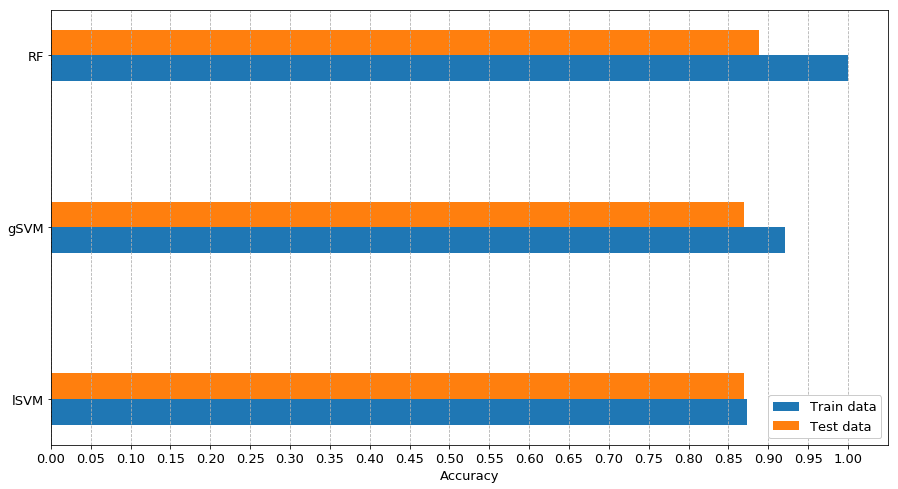

,Train data,Test data
lSVM,0.874,0.869
gSVM,0.921,0.870
RF,1.000,0.889


In [14]:
# Overall information showing the absence of overfitting
accs = arab_plot_accs(Xa_train, Xa_test, ya_train, ya_test, clfs_a)
accs

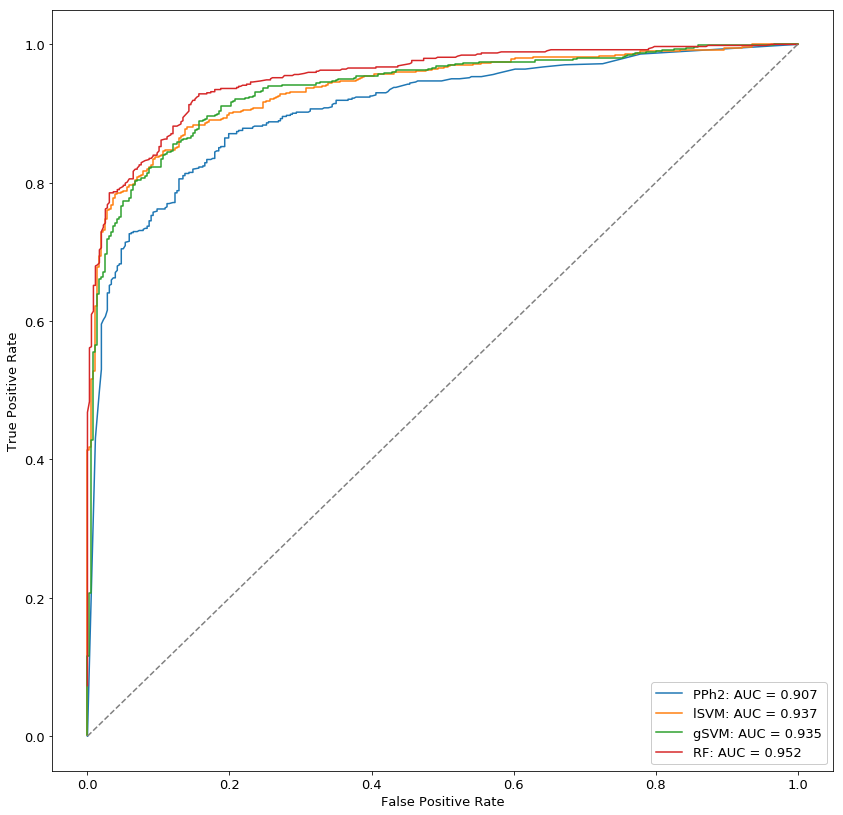

In [15]:
# ROC-curves for all classifiers related with A. thaliana
roc_curves(tab_a, is_arab=True)

In [16]:
# Confusion matrixes for all classifiers related with A. thaliana
mets_mats_arab(tab_a)[0]

PPh2                        lSVM                \
           Predicted_Neu Predicted_Del Predicted_Neu Predicted_Del   
Actual_Neu           293            64           296            61   
Actual_Del           100           543            70           573   

                    gSVM                          RF                
           Predicted_Neu Predicted_Del Predicted_Neu Predicted_Del  
Actual_Neu           301            56           306            51  
Actual_Del            74           569            60           583

In [17]:
# Table with metrics for all classifiers related with A. thaliana
mets_mats_arab(tab_a)[1] 

,PPh2,lSVM,gSVM,RF
Accuracy,0.836,0.869,0.870,0.889
FPR,0.179,0.171,0.157,0.143
FNR,0.156,0.109,0.115,0.093
Sensetivity,0.844,0.891,0.885,0.907
Specificity,0.821,0.829,0.843,0.857
AUC,0.907,0.937,0.935,0.952


# ROC-curves and Metrics for O. sativa

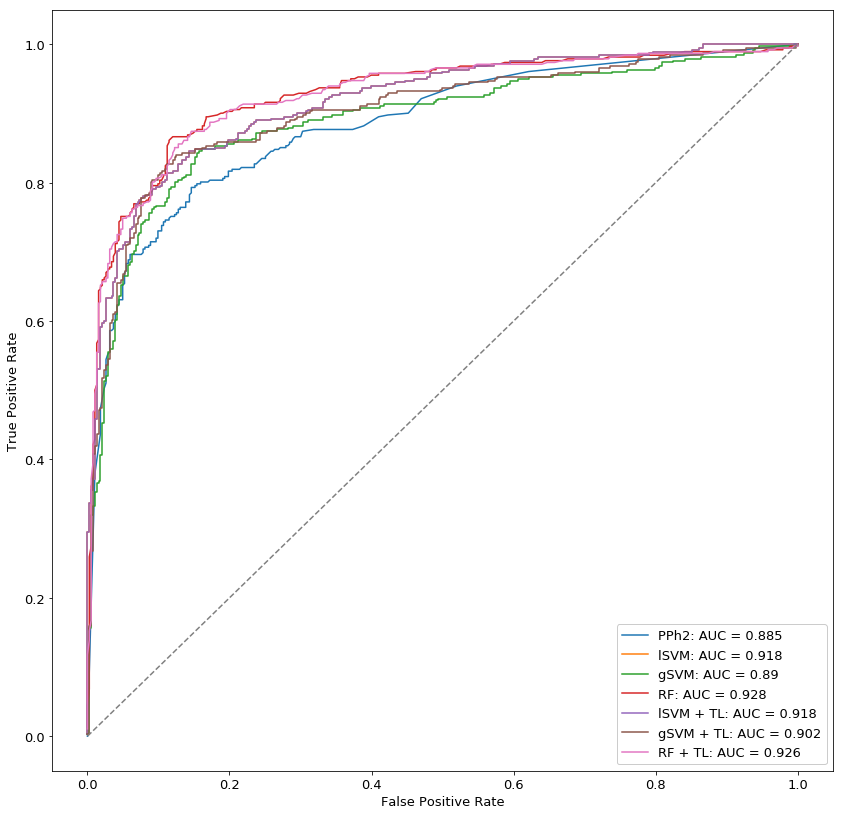

In [18]:
# ROC-curves for all classifiers related with O. sativa
roc_curves(tab_o, is_arab=False)

In [19]:
# Table with metrics for all classifiers related with O. sativa
mets_others(tab_o)

,Accuracy,FPR,FNR,AUC
PPh2,0.814,0.102,0.270,0.885
lSVM,0.848,0.144,0.160,0.918
gSVM,0.842,0.164,0.152,0.890
RF,0.873,0.115,0.139,0.928
lSVM + TL,0.848,0.144,0.160,0.918
gSVM + TL,0.803,0.285,0.110,0.902
RF + TL,0.861,0.128,0.149,0.926


# ROC-curves and Metrics for P. sativum

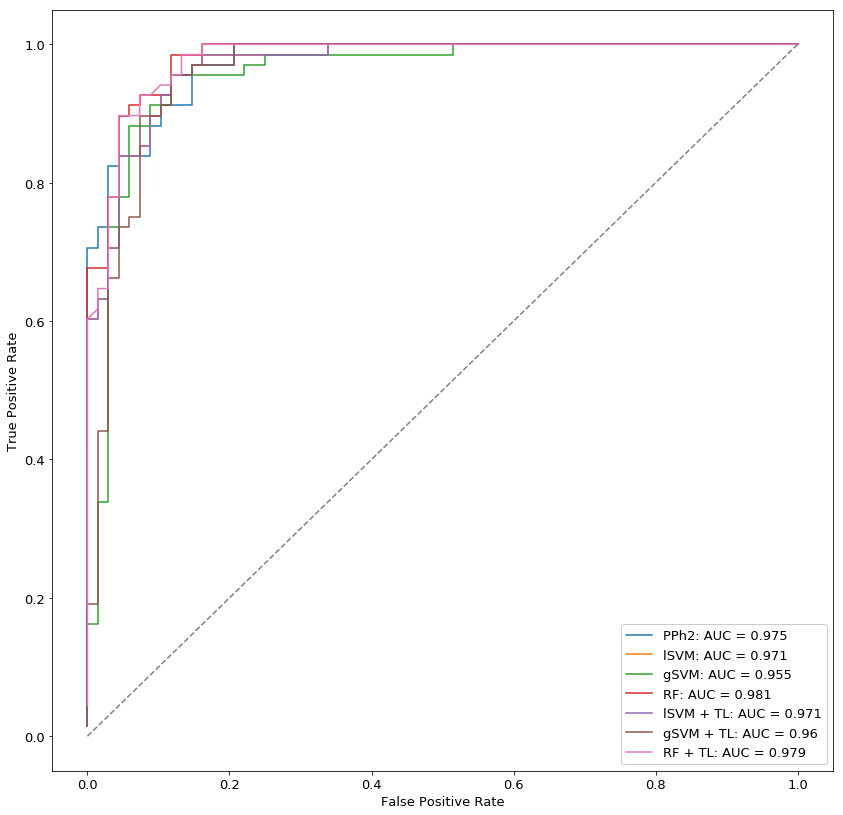

In [20]:
# ROC-curves for all classifiers related with P. sativum
roc_curves(tab_p, is_arab=False)

In [21]:
# Table with metrics for all classifiers related with P. sativum
mets_others(tab_p)

,Accuracy,FPR,FNR,AUC
PPh2,0.897,0.044,0.162,0.975
lSVM,0.912,0.103,0.074,0.971
gSVM,0.912,0.088,0.088,0.955
RF,0.926,0.074,0.074,0.981
lSVM + TL,0.912,0.103,0.074,0.971
gSVM + TL,0.904,0.147,0.044,0.960
RF + TL,0.919,0.088,0.074,0.979


# Resulting Table for C. arietinum 

In [22]:
# C. arietinum table
tab_c = cicer_table(subs_c, Xc, stdXc, pph2_pred_c, rf_wo)

# Save the table for a further analysis
tab_c.to_csv('freq_cicer/cicer_resulting_table.tsv', sep='\t')